In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv("test.csv")

df.head()

,username,movie#1,movie#2,movie#3,movie#4,movie#5,movie#6,movie#7,movie#8,movie#9,movie#10
0,id#0,7,15,12,24,48,57,27,37,65,83
1,id#1,7,5,22,36,25,4,16,16,88,0
2,id#2,9,7,28,33,35,58,62,63,45,70
3,id#3,9,17,9,39,35,30,60,49,49,99
4,id#4,4,11,8,22,10,58,6,59,88,25


In [2]:
#clean data
df.replace(np.NaN, 0, inplace=True)
df.head()

,username,movie#1,movie#2,movie#3,movie#4,movie#5,movie#6,movie#7,movie#8,movie#9,movie#10
0,id#0,7,15,12,24,48,57,27,37,65,83
1,id#1,7,5,22,36,25,4,16,16,88,0
2,id#2,9,7,28,33,35,58,62,63,45,70
3,id#3,9,17,9,39,35,30,60,49,49,99
4,id#4,4,11,8,22,10,58,6,59,88,25


In [ ]:
def get_neig(df: pd.DataFrame, i: int, k: int) -> pd.DataFrame:
    scores_table = df[df.columns[1:]]
    row = scores_table.iloc[i]
    distances = np.linalg.norm(scores_table -row, axis=1)

    distances.head();
    #+1 to remove the user from user neighbors
    nearest_neighbor_ids = distances.argsort()[1:k+1]
    nearest_neighbors = scores_table.iloc[nearest_neighbor_ids]
    return nearest_neighbors  # type: ignore


In [4]:
import math
from scipy import stats
#constants
CONST_K = 4
CONST_RATING_POINT = 75

#helper funcs

#get scores from dataframe
def get_scores(df, i):
    return df.iloc[[i]][df.columns[1:]].values[0]

#my implementation of corelation coefficient
def get_wij(row_i, row_j):
    average_i = np.average(row_i)
    average_j = np.average(row_j)

    top_a = row_i - average_i
    top_b = row_j - average_j

    top_array = top_a * top_b
    top_value = np.sum(top_array)

    bottom_a_squared = top_a ** 2
    bottom_b_sum = np.sum(bottom_a_squared)
    bottom_a_root = np.sqrt(bottom_b_sum)

    bottom_b_squared = top_b ** 2
    bottom_b_sum = np.sum(bottom_b_squared)
    bottom_b_root = np.sqrt(bottom_b_sum)

    bottom_value = bottom_a_root * bottom_b_root

    return top_value/bottom_value


#get rating based on i=row, a=col, k=number of neighbors
def get_rating(df: pd.DataFrame, i: int, a:int, k: int):
    person_scores = get_scores(df, i)
    person_average = np.average(person_scores)

    top = 0
    bottom = 0

    neighbors_scores = get_neig(df, i, k)
    # neighbors_scores = df[df.columns[1:]][1:]

    #rating formula implementation
    selected = np.array(neighbors_scores[neighbors_scores.columns[a]])
    averages = np.average(neighbors_scores, axis=1)
    corelations = neighbors_scores.apply(lambda row: get_wij(person_scores, row), axis=1)

    selected_minus_average = selected - averages
    top_array = selected_minus_average * corelations
    top_value = np.sum(top_array)
    
    bottom_array = np.abs(corelations)
    bottom_value = np.sum(bottom_array)
    
    rating = (top_value / bottom_value) + person_average

    return rating

#test example
get_rating(df, 3, 2, CONST_K)

13.882062169893032

In [5]:
#point of split into should and should not watch

def should_watch(df: pd.DataFrame, i: int, a: int, k: int = 8):
    rating = get_rating(df, i, a, k)
    return rating >= CONST_RATING_POINT

#test example
should_watch(df, 3, 2)

False

<BarContainer object of 2 artists>

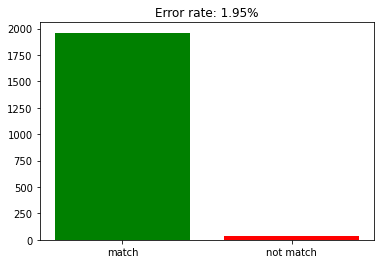

In [6]:
from decimal import DivisionByZero
import matplotlib.pyplot as plt
#match/not match review
def test_should_watch_diff(df: pd.DataFrame, k: int):
  row_len = len(df)
  col_len = len(df.columns)
  diff = []
  for row_index in range(row_len):
    scores = get_scores(df, row_index)
    for score_index, score in enumerate(scores):
      calc_value = should_watch(df, row_index, score_index, k)
      real_value = score >= CONST_RATING_POINT
      diff.append(calc_value == real_value)
  return diff

def percentage(part, whole):
  return 100 * float(part)/float(whole)

def go_test_watch(k: int = 1):

  watch_diff = test_should_watch_diff(df, k)
  matches = list(filter(lambda x: x == True, watch_diff))
  not_matches = list(filter(lambda x: x == False, watch_diff))

  correct_matches_len = len(matches)
  wrong_matches_len = len(not_matches)
  error_rate = percentage(wrong_matches_len, len(watch_diff))
  return correct_matches_len, wrong_matches_len, error_rate



correct, wrong, error_rate = go_test_watch(CONST_K)
plt.title(f"Error rate: {error_rate}%")
plt.bar(["match", "not match"], [correct, wrong], color=["green", "red"])


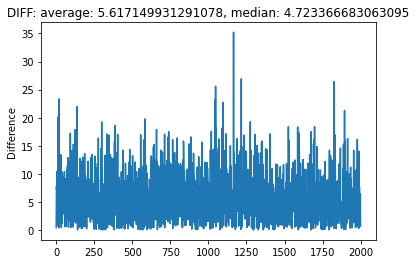

In [7]:
#score review
def test_score_diff(df: pd.DataFrame, k: int):
    diff_arr = []
    for row_idx in range(len(df)):
        scores = get_scores(df, row_idx)
        for score_idx, score in enumerate(scores):
            calc_score = get_rating(df, row_idx, score_idx, k)
            diff = abs(score - calc_score)
            diff_arr.append(diff)
    
    return diff_arr

diff = test_score_diff(df, CONST_K)

plt.title(f"DIFF: average: {np.average(diff)}, median: {np.median(diff)}")
plt.ylabel("Difference")
plt.plot(np.arange(len(diff)), diff)